# Daily changes in spatial accessibility to intensive care unit (ICU) beds and their relationship with the case-fatality ratio of COVID-19 in the state of Texas

**Authors**: Jinwoo Park <sup>1,2</sup>, Alexander Michels<sup>1,2</sup>, Fangzheng Lyu<sup>1,2</sup>, Su Yeon Han<sup>1,2</sup>, and Shaowen Wang<sup>1,2,*</sup> <br>
<sup>1</sup> Department of Geography and Geographic Information Science, University of Illinois Urbana-Champaign <br>
<sup>2</sup> CyberGIS Center for Advanced Digital and Spatial Studies, University of Illinois Urbana-Champaign <br>
<sup>*</sup> Correspondence: Shaowen Wang, shaowen@illinois.edu <br>

Last Updated Date: Feb 10, 2023

### Abstract:
During the COVID-19 pandemic, many patients could not receive timely healthcare services due to limited access to hospital infrastructure and human resources. Previous studies found that access to intensive care unit (ICU) beds saves lives, but they overlooked the temporal dynamics in the availability of healthcare resources and COVID-19 cases. To fill this gap, our study investigated daily changes in ICU bed accessibility with an enhanced two-step floating catchment area (E2SFCA) method. Along with the increased temporal granularity of measurements, we uncovered two phenomena: 1) aggravated spatial inequality of access during the pandemic and 2) the retrospective relationship between insufficient ICU bed accessibility and the high case-fatality ratio of COVID-19 in rural and suburban counties. Given our findings, we suggest that those locations should be supplemented with additional healthcare resources to save lives in future pandemic scenarios.

### Keywords:
Spatial accessibility, COVID-19, Healthcare resources, Temporal dynamics, ICU beds

### Notebook Outline 
***Hyperlinks work only within the Jupuyter environment***

* <a href='#1.-Introduction'>Introduction</a>
    * <a href='#1.1.-Study-area-and-period'>Study area and period</a>
    * <a href='#1.2.-Research-workflow'>Research workflow</a>
* <a href='#2.-Accessibility-measurements'>Accessibility measurements</a>
    * <a href='#2.1.-Input-variables'>Input variables</a>
    * <a href='#2.2.-Dynamic-measurements-(considering-temporal-changes-of-values)'>Dynamic measurements</a>
    * <a href='#2.3.-Static-measurement-(ignoring-temporal-changes-of-values)'>Static measurement</a>
* <a href='#3.-Correlation-analysis'>Correlation analysis</a>
    * <a href='#3.1.-Correlation-across-the-space-and-time'>Correlation across the space and time</a>
    * <a href='#3.2.-Retrospective-relationship-per-county'>Retrospective relationship per county</a>
* <a href="#4.-Inequality-assessments">Inequality assessments</a>

# 1. Introduction

## 1.1. Study area and period

Our study area is the state of Texas, which is the second-most populous state (29 million), and the study period is from July 1st, 2020, to December 31st, 2021 (18 months) to cover the starting point of the first major spread of COVID-19 in Texas (July 2020) to the present.

<img src="./images/study_area_period.jpg" width="800">

## 1.2. Research workflow

Our study proceeds in four steps: 1) data preprocessing, 2) accessibility measurements, 3) correlation analysis, and 4) inequality assessment. 

1. **The data processing step** aimed to populate temporal changes in supply (availability of ICU beds per hospital) and demand (confirmed COVID-19 cases per census tract). We also precomputed a travel time matrix between the hospitals (supply locations) and census tracts (demand locations) to facilitate further analysis. <br>
2. **Accessibility measurements step** utilized an E2SFCA method to assess spatial accessibility to healthcare resources during the COVID-19 pandemic under the interaction between the temporal changes of available ICU beds (supply) and the accumulated COVID-19 cases (demand). <br>
3. **Correlation analysis step** compared the daily accessibility and case-fatality ratio of COVID-19 per each county over time to uncover the retrospective linkage between increased death and insufficient access. <br>
4. **Inequality assessment step** calculated the daily changes in access inequality with the Gini index. <br>
**Note:** In the third and fourth steps, we also examined different results obtained from static (without temporal changes) and dynamic (with temporal changes) accessibility measurements and explored the benefits of incorporating temporal aspects into spatial accessibility assessments.

<img src="./images/workflow_new.jpg" width="1000">

In [1]:
import utils
import geopandas as gpd
import pandas as pd
import multiprocessing as mp
import itertools
import os
import datetime
import mapclassify
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import statsmodels.api as sm
from tqdm import tqdm
import numpy as np
from itertools import product
import warnings
warnings.filterwarnings("ignore")

try:
    from matplotlib_scalebar.scalebar import ScaleBar
except:
    !pip install matplotlib_scalebar
    from matplotlib_scalebar.scalebar import ScaleBar

# Define paths
data = './data'

Defaulting to user installation because normal site-packages is not writeable


# 2. Accessibility measurements

We utilized an E2SFCA method to assess daily changes in spatial accessibility to ICU beds during the COVID-19 pandemic under the interaction between the temporal changes of available ICU beds (supply) and the accumulated COVID-19 cases (demand). In addition, we replicated the conventional approach from the literature, which ignores temporal changes in supply and demand. The details of implemented variables in both approaches are as follows. 

| Variables | Static Measurement (without temporal changes) | Dynamic Measurements (Daily changes) |
| --- | --- | --- |
| Supply | Staffed ICU beds | Available ICU beds each day |
| Demand | Overall COVID-19 cases | Daily confirmed COVID-19 cases |
| Mobility | Travel time between supply and demand locations | 
| Threshold travel time | 60 minutes | 
| Distance decay | Log-logistics distribution | 


## 2.1. Input variables

In [2]:
# Retrieve each date between '07/01/2020' and '12/31/2021'
focus_date_dict = utils.calculate_focus_date_dict(from_date='07/01/2020', to_date='12/31/2021', delta_days=1)

### Supply

In [3]:
# Supply locations
s_loc = gpd.read_file(os.path.join(data, 'access', 'input_files', 'hospital_geocode.json'))
s_loc = s_loc.set_index('HC_ID')
s_loc = s_loc.fillna(0)
s_loc.head(3)

,Type,Zip,County,Staffed_Beds,ICU_Beds,FIPS,TSA,lat,lng,geometry
HC_ID,,,,,,,,,,
H000,Short Term Acute Care Hospital,75001,Dallas,32.0,4,48113,E,32.984766,-96.829405,POINT (1295826.606 1205448.145)
H001,Short Term Acute Care Hospital,75006,Dallas,0.0,0,48113,E,32.986187,-96.898161,POINT (1289408.831 1205423.487)
H002,Short Term Acute Care Hospital,75039,Dallas,80.0,8,48113,E,32.902051,-96.957361,POINT (1284142.861 1195958.149)


In [4]:
# Temporal variation of supply (ICU bed availability per TSA)
s_val = pd.read_csv(os.path.join(data, 'access/input_files/ICU_beds_available_ratio.csv'))
s_val = s_val.rename(columns={'Unnamed: 0': 'TSA'})
s_val = s_val.set_index('TSA')
s_val = s_val[focus_date_dict.keys()]
s_val.head(3)

,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,07/06/2020,07/07/2020,07/08/2020,07/09/2020,07/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
TSA,,,,,,,,,,,,,,,,,,,,,
A,0.317819,0.333422,0.340915,0.342459,0.349128,0.359759,0.368269,0.370569,0.371992,0.370999,...,0.728145,0.740988,0.738856,0.739182,0.733426,0.726083,0.719666,0.716422,0.713155,0.705444
B,0.378566,0.380428,0.380377,0.379608,0.392440,0.409008,0.404519,0.393537,0.395113,0.395455,...,0.307257,0.302030,0.294652,0.296121,0.288592,0.274839,0.279791,0.272531,0.267281,0.267533
C,0.404758,0.399362,0.405265,0.406376,0.413519,0.434085,0.460256,0.478059,0.507147,0.524706,...,0.353604,0.338128,0.336132,0.349737,0.338605,0.351871,0.347585,0.363849,0.378286,0.356786


### Demand

In [5]:
# Demand location (census tract)
d_loc = gpd.read_file('./data/reference_data/geographic_units/tract_reference.shp')
d_loc.set_index('County', inplace=True)

d_val_static = pd.read_csv('./data/reference_data/covid_data/daily_covid_case.csv')
d_val_static.set_index('County', inplace=True)
d_val_static = d_val_static.sum(axis=1)
d_val_static = pd.DataFrame(d_val_static, columns=['cases_county'])
d_val_static.head(1)

d_loc = d_loc.merge(d_val_static, left_index=True, right_index=True)
d_loc['cases_tract'] = d_loc['pop_ratio'] * d_loc['cases_county']
d_loc.reset_index(inplace=True)
d_loc.set_index('GEOID', inplace=True)
d_loc.head(1)

,County,TSA,pop,pop_ratio,geometry,cases_county,cases_tract
GEOID,,,,,,,
48001950100,Anderson,G,4844,0.083792,"POLYGON ((1405776.557 1097438.688, 1405779.438...",5877.0,492.444006


In [6]:
# Demand daily variation (accumulated COVID-19 cases for 25 days)
# Recovery date from COVID-19 for worse symptom: 18.70±2.50
# https://onlinelibrary.wiley.com/doi/pdf/10.1111/joim.13063

d_val = pd.read_csv(os.path.join(data, 'access/input_files/estimated_covid_case.csv'))
d_val = d_val.set_index('GEOID')
d_val = d_val.drop(columns=['FIPS', 'CTID', 'Pop_Ratio', 'County_Pop', 'Tract_Pop'])
d_val.head(3)

,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,06/09/2020,06/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
GEOID,,,,,,,,,,,,,,,,,,,,,
48001950100,2.294050,4.982843,4.635778,5.781797,6.321081,6.237038,6.101965,6.076660,6.327365,6.683480,...,3.192800,3.474173,3.428422,3.810764,3.860704,4.249162,4.389262,5.295805,5.465651,5.656193
48001950401,2.291209,4.976671,4.630035,5.774635,6.313251,6.229312,6.094407,6.069133,6.319528,6.675201,...,3.188845,3.469870,3.424176,3.806044,3.855922,4.243899,4.383826,5.289245,5.458881,5.649187
48001950402,3.557104,7.726287,7.188135,8.965128,9.801329,9.671013,9.461573,9.422336,9.811073,10.363257,...,4.950686,5.386976,5.316037,5.908887,5.986323,6.588658,6.805894,8.211559,8.474918,8.770369


### Mobility

In [7]:
# Precomputed travel time matrix between supply and demand locations
mobility_df = pd.read_csv(os.path.join(data, 'access/input_files/Precalculated_OD_Matrix.csv'))
mobility_df['GEOID'] = mobility_df['GEOID'].astype(str)
mobility_df.head(3)

,HC_ID,GEOID,trvl_time
0,H000,48439121609,39.038224
1,H000,48251130208,52.587246
2,H000,48251131000,65.449505


## 2.2. Dynamic measurements (considering temporal changes of values)

In [8]:
# # Following cell was run on Keeling due to multiprocessing capability 
# # The actual file used is 'ICU_Accessibility_Measurements.py' in 'other_notebooks' folder
# # Keeling will save the file in 'data/access/ICU_access_measures/keeling'
# # `acc_step1_{date}.csv` is the step 1 of E2SFCA method on `date`
# # `acc_step2_{date}.csv` is the step 2 of E2SFCA method on `date`

# if __name__ == "__main__":
#     pool = mp.Pool(8)
#     pool.map(utils.measure_accessibility_unpacker,
#              zip(itertools.repeat(s_loc),
#                  itertools.repeat(d_loc),
#                  itertools.repeat(s_val),
#                  itertools.repeat(d_val),
#                  itertools.repeat(mobility_df),
#                  focus_date
#                 )
#              )
#     pool.close()

In [9]:
# Retrived dynamic measurements, which were remotely computed on Keeling
access_tract = d_loc.copy(deep=True)

for date in tqdm(focus_date_dict.keys()):
    date_ = date.replace('/', '_')
    temp_result = pd.read_csv(os.path.join(data, 'access', 'ICU_access_measures', 'keeling', f'acc_step2_{date_}.csv'))
    temp_result['GEOID'] = temp_result['GEOID'].astype(str)
    temp_result = temp_result.set_index('GEOID')
    access_tract = access_tract.merge(temp_result, left_index=True, right_index=True)
    
# access_tract.to_file('./data/access/ICU_access_measures/ICU_access_tract.shp')
access_tract.head(3)

100%|██████████| 549/549 [00:33<00:00, 16.51it/s]


,County,TSA,pop,pop_ratio,geometry,cases_county,cases_tract,07/01/2020,07/02/2020,07/03/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
GEOID,,,,,,,,,,,,,,,,,,,,,
48001950100,Anderson,G,4844,0.083792,"POLYGON ((1405776.557 1097438.688, 1405779.438...",5877.0,492.444006,0.131204,0.123441,0.107302,...,0.064546,0.064050,0.060124,0.055479,0.054511,0.051298,0.050511,0.046274,0.045132,0.044856
48001950401,Anderson,G,4838,0.083688,"POLYGON ((1392461.585 1072740.298, 1392447.163...",5877.0,491.834043,0.013363,0.013289,0.013271,...,0.026698,0.025816,0.024654,0.022230,0.021633,0.020381,0.020269,0.018124,0.017697,0.017364
48001950402,Anderson,G,7511,0.129926,"POLYGON ((1379516.856 1075774.243, 1379519.198...",5877.0,763.572859,0.009972,0.009869,0.009757,...,0.016435,0.015967,0.015210,0.013791,0.013458,0.012687,0.012578,0.011292,0.011014,0.010851


Classification intervals: [0.0338662  0.07240271 0.1303281  0.22706053 0.39204555 0.69476281
 1.        ]


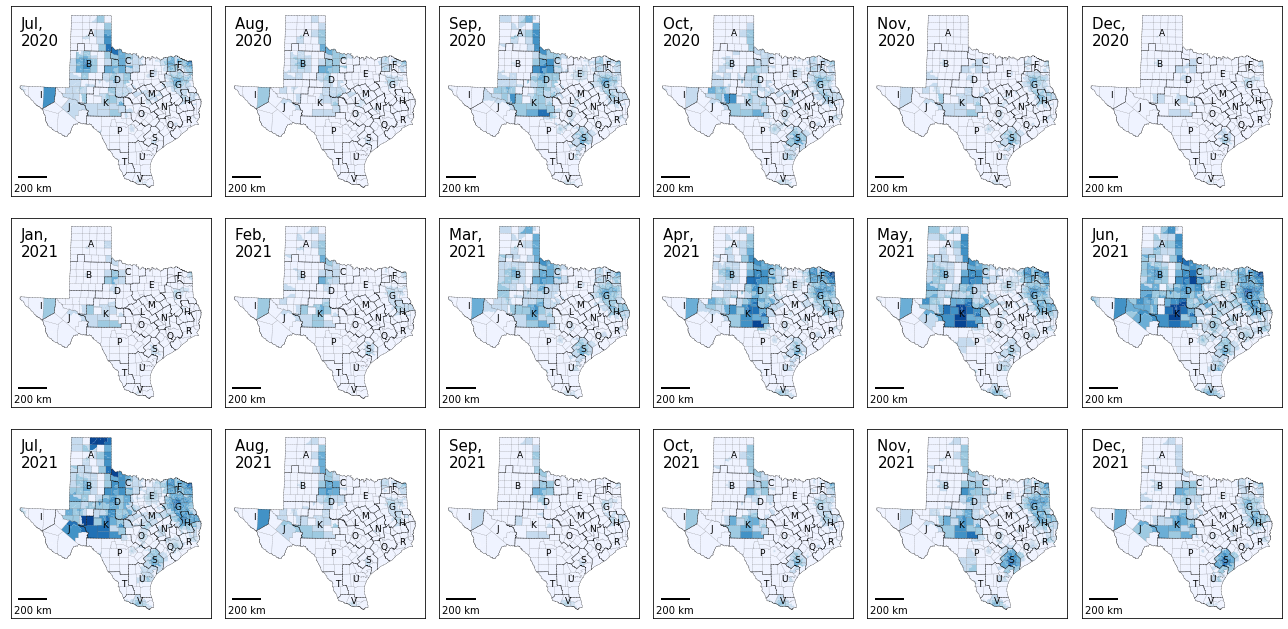

In [10]:
# Load boundary of TSA and counties for plotting purpose
# County Geometry
county_geom = gpd.read_file(os.path.join(data, 'reference_data', 'geographic_units', 'county_reference.shp'))

# TSA Geometry
tsa_geom = county_geom.dissolve(by='TSA', aggfunc='sum')
tsa_geom.reset_index(inplace=True)

# Define classes for Choropleth map
access_tract_val = access_tract[focus_date_dict.keys()].values.reshape(-1)

# Accessibiltiy more than 1 is unnecessary
access_tract_val[access_tract_val>1] = 1 
map_class_acc_tract = mapclassify.NaturalBreaks(access_tract_val, k=7)
print(f'Classification intervals: {map_class_acc_tract.bins}')

period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]
# Define color map
color_brewer = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)

fig, axes = plt.subplots(3, 6, figsize=(18,9))
ax = axes.reshape(-1)
for idx, m in enumerate(period):
    access_tract.plot(column=m, 
                      ax = ax[idx],
                      cmap=cm,
                      scheme='user_defined',
                      classification_kwds={'bins':map_class_acc_tract.bins} # then speicfy class here.
                     )
    tsa_geom.boundary.plot(ax=ax[idx], lw=0.3, color='black', linestyle='dashed')
    county_geom.boundary.plot(ax=ax[idx], lw=0.15, color='black', linestyle='dotted')
    
    for idx_1, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
        ax[idx].text(s=row['TSA'], # String to be displayed; TSA name
                     x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
                     y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label            
                     fontsize=9, 
                     color='black',
                     ha='center', # Horizontal align
                     va='center', # Vertical align
                    )
    
    month_text = datetime.datetime.strptime(m, '%m/%d/%Y')
    month_text = month_text.strftime('%b, \n%Y')
    ax[idx].text(0.05, 0.95, s=month_text, fontsize=15, ha='left', va='top', transform=ax[idx].transAxes)
    ax[idx].add_artist(ScaleBar(dx=1, location='lower left'))
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].get_yaxis().set_visible(False)
    
plt.tight_layout() # Will shrink empty area
plt.show()

## 2.3. Static measurement (ignoring temporal changes of values)

In [11]:
# DISTANCE DECAY
minutes = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 60]
weights = {0: 1, 5: 0.9459, 10: 0.7544, 15: 0.5511, 20: 0.3993, 25: 0.2957, 30: 0.2253, 35: 0.1765, 40: 0.1417, 45: 0.1161, 60: 0.0832}


supply_demand_ratio_static = s_loc.filter(['ICU_Beds', 'geometry'], axis=1)
supply_demand_ratio_static['ratio'] = 0.0

# Step 1 of E2SFCA
for s_idx in tqdm(supply_demand_ratio_static.index):
    temp_supply = s_loc.at[s_idx, 'ICU_Beds']

    temp_ctmt = mobility_df.loc[mobility_df['HC_ID'] == s_idx]

    temp_demand = 0
    for idx, minute in enumerate(minutes):
        if idx != 0:
            temp_ctmt_geoid = temp_ctmt.loc[(minutes[idx - 1] < temp_ctmt['trvl_time'])
                                            & (temp_ctmt['trvl_time'] <= minute), 'GEOID'].to_list()
            temp_demand += d_loc.loc[temp_ctmt_geoid, 'cases_tract'].sum() * weights[minute]
    temp_ratio = temp_supply / temp_demand
    supply_demand_ratio_static.at[s_idx, 'ratio'] = temp_ratio

supply_demand_ratio_static.head(1)

100%|██████████| 652/652 [00:25<00:00, 25.17it/s]


,ICU_Beds,geometry,ratio
HC_ID,,,
H000,4,POINT (1295826.606 1205448.145),0.000014


In [12]:
access_tract_static = d_loc.filter(['County', 'TSA', 'pop', 'geometry'], axis=1)
access_tract_static['access'] = 0.0

for d_idx in tqdm(access_tract_static.index):
    temp_ctmt_2 = mobility_df.loc[mobility_df['GEOID'] == d_idx]
    temp_ratio = 0
    for idx, minute in enumerate(minutes):
        if idx != 0:
            temp_ctmt_hc_id = temp_ctmt_2.loc[(minutes[idx - 1] < temp_ctmt_2['trvl_time'])
                                              & (temp_ctmt_2['trvl_time'] <= minute), 'HC_ID'].to_list()
            temp_ratio += supply_demand_ratio_static.loc[temp_ctmt_hc_id, 'ratio'].sum() * weights[minute]

    access_tract_static.at[d_idx, 'access'] = temp_ratio

# access_tract_static.to_file('./data/access/ICU_access_measures/static_measurement/ICU_access_tract_static.shp')
access_tract_static.head(1)

100%|██████████| 5265/5265 [03:30<00:00, 25.02it/s]


,County,TSA,pop,geometry,access
GEOID,,,,,
48001950100,Anderson,G,4844,"POLYGON ((1405776.557 1097438.688, 1405779.438...",0.00281


Classification intervals: [0.00138915 0.00228743 0.00320943 0.00456502 0.00663502 0.01085837
 0.01621163]


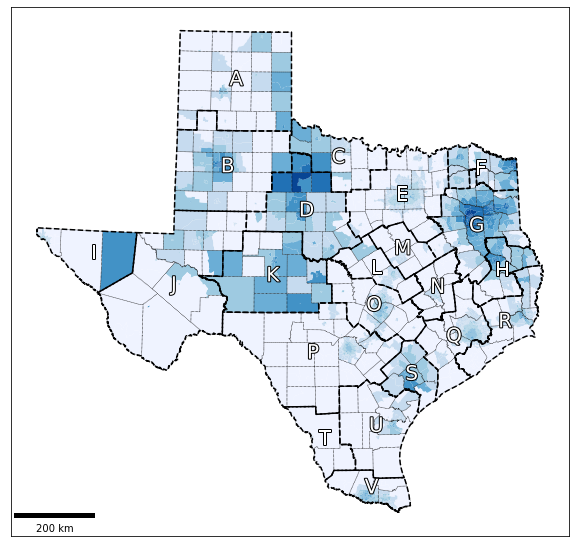

In [13]:
# Define color map
color_brewer = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#084594']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=7)

print(f'Classification intervals: {mapclassify.NaturalBreaks(access_tract_static["access"], k=7).bins}')

fig, ax = plt.subplots(figsize=(10,10))

access_tract_static.plot(column='access', 
                  ax = ax,
                  cmap=cm,
                  scheme='NaturalBreaks',
#                   legend=True,
                  k=7
                 )

county_geom.boundary.plot(ax=ax, lw=0.5, color='black', linestyle='dotted')
tsa_geom.boundary.plot(ax=ax, lw=1.5, color='black', linestyle='dashed')

for idx, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
    ax.text(s=row['TSA'], # String to be displayed; TSA name
            x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
            y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label
            fontsize=20, 
            color='white',
            ha='center', # Horizontal align
            va='center', # Vertical align
            path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
           )

# ax.text(0.05, 0.95, s='Static', fontsize=30, ha='left', va='top', transform=ax.transAxes)
ax.add_artist(ScaleBar(dx=1, location='lower left'))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# 3. Correlation analysis

We investigated the relationship between ICU bed accessibility and the case-fatality ratio of COVID-19 at a county level. In detail, we employed Kendall’s tau correlation coefficients because the distributions of those two variables are not linear. The method considers the variables based on their ranks but keeps their pairs. In addition, we compared the correlation coefficients between static and dynamic measurements and investigate how the static implementation may bias the interpretation of the retrospective linkage between insufficient access and increased case-fatality ratio. 

## 3.1. Correlation across the space and time 

### Dynamic measurements related variables

In [14]:
access_county_dynamic = county_geom.copy(deep=True)
county_list = county_geom['County'].tolist()

for date in tqdm(focus_date_dict.keys()):
    for temp_county in county_list:
        temp_pop_tract = access_tract.loc[access_tract['County'] == temp_county, 'pop']
        temp_access_tract = access_tract.loc[access_tract['County'] == temp_county, date]
        
        temp_access_county = sum(temp_pop_tract * temp_access_tract)
        temp_pop_county = access_county_dynamic.loc[access_county_dynamic['County'] == temp_county, 'pop'].values[0]
        
        access_county_dynamic.loc[access_county_dynamic['County'] == temp_county, date] = temp_access_county / temp_pop_county

        
access_county_dynamic.to_file('./data/access/ICU_access_measures/ICU_access_county.shp')
access_county_dynamic.head(3)

100%|██████████| 549/549 [06:25<00:00,  1.42it/s]


,GEOID,TSA,pop,County,geometry,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
0,48001,G,57810,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136...",0.060118,0.057291,0.051498,0.050710,0.051960,...,0.051158,0.050036,0.047434,0.043208,0.042242,0.039766,0.039385,0.035573,0.034726,0.034278
1,48003,J,18036,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1...",0.150403,0.142023,0.128327,0.124644,0.132778,...,0.046511,0.043150,0.041219,0.043147,0.045863,0.047996,0.049757,0.043156,0.035082,0.032366
2,48005,H,87322,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ...",0.081069,0.066774,0.065946,0.068897,0.073690,...,0.135319,0.122951,0.127396,0.141494,0.140217,0.131490,0.122598,0.108991,0.105272,0.089118


In [15]:
# Calculate COVID-19 confirmation
ave_case = pd.read_csv(os.path.join(data, 'reference_data', 'covid_data', 'averaged_covid_case.csv'))
ave_case_geom = county_geom.merge(ave_case, on='County')

# Calculate COVID-19 death 
ave_death = pd.read_csv(os.path.join(data, 'reference_data', 'covid_data', 'averaged_covid_death.csv'))
ave_death_geom = county_geom.merge(ave_death, on='County')

ave_fatality_geom = ave_death_geom.copy(deep=True)
for date in focus_date_dict.keys():
    ave_fatality_geom[date] = ave_death_geom[date] / ave_case_geom[date] * 1000

ave_fatality_geom.fillna(0, inplace=True)

for idx, row in ave_fatality_geom.iterrows():
    for date in focus_date_dict.keys():
        
        if row[date] == np.inf:
            ave_fatality_geom.loc[idx, date] = ave_fatality_geom.loc[ave_fatality_geom[date] != np.inf, date].max()
            
ave_fatality_geom.head(3)

,GEOID,TSA,pop,County,geometry,07/01/2020,07/02/2020,07/03/2020,07/04/2020,07/05/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
0,48001,G,57810,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136...",23.809524,22.727273,20.833333,17.543860,0.000000,...,37.037037,74.074074,66.666667,100.000000,71.428571,50.000000,47.619048,57.142857,31.250000,40.000000
1,48003,J,18036,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1...",0.000000,111.111111,55.555556,47.619048,40.000000,...,41.666667,43.478261,0.000000,55.555556,32.258065,20.833333,16.949153,16.949153,16.949153,16.949153
2,48005,H,87322,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ...",20.202020,19.801980,36.697248,31.496063,32.786885,...,28.571429,23.809524,22.222222,22.222222,18.181818,18.181818,13.888889,15.151515,16.949153,20.000000


In [16]:
county_list = county_geom['County'].tolist()
corr_dynamic = pd.DataFrame(list(product(county_list, focus_date_dict.keys())), columns=['County', 'Date'])

for idx, row in tqdm(corr_dynamic.iterrows(), total=corr_dynamic.shape[0]):
    corr_dynamic.loc[idx, 'access'] = access_county_dynamic.loc[access_county_dynamic['County'] == row['County'], row['Date']].values[0]
    corr_dynamic.loc[idx, 'fatality'] = ave_fatality_geom.loc[ave_fatality_geom['County'] == row['County'], row['Date']].values[0]
    
corr_dynamic.head()

100%|██████████| 139446/139446 [06:28<00:00, 358.84it/s]


,County,Date,access,fatality
0,Anderson,07/01/2020,0.060118,23.809524
1,Anderson,07/02/2020,0.057291,22.727273
2,Anderson,07/03/2020,0.051498,20.833333
3,Anderson,07/04/2020,0.050710,17.543860
4,Anderson,07/05/2020,0.051960,0.000000


### Static measurement related variables

In [17]:
case_ccounty = pd.read_csv('./data/reference_data/covid_data/daily_covid_case.csv')
case_ccounty.set_index('County', inplace=True)
case_ccounty = case_ccounty.sum(axis=1)
case_ccounty = pd.DataFrame(case_ccounty, columns=['cases_county'])

death_county = pd.read_csv(os.path.join(data, 'reference_data', 'covid_data', 'daily_covid_death.csv'))
death_county = death_county.set_index('County')
death_county = death_county.sum(axis=1)
death_county = pd.DataFrame(death_county, columns=['death_county'])

fatality_county = case_ccounty.merge(death_county, left_index=True, right_index=True)
fatality_county.reset_index(inplace=True)

fatality_county = county_geom.merge(fatality_county, on='County')
fatality_county['mortality'] = fatality_county['death_county'] / fatality_county['pop'] * 100000
fatality_county['fatality'] = fatality_county['death_county'] / fatality_county['cases_county'] * 1000
fatality_county.head(3)

,GEOID,TSA,pop,County,geometry,cases_county,death_county,mortality,fatality
0,48001,G,57810,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136...",5877.0,207,358.069538,35.222052
1,48003,J,18036,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1...",2462.0,65,360.390330,26.401300
2,48005,H,87322,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ...",6762.0,403,461.510272,59.597752


In [18]:
access_county_static = gpd.read_file(os.path.join(data, 'access/ICU_access_measures/static_measurement/ICU_access_county_static.shp'))
access_county_static.head(5)

,GEOID,TSA,pop,County,access,geometry
0,48001,G,57810,Anderson,0.002099,"POLYGON ((1440392.625 1070275.995, 1440394.136..."
1,48003,J,18036,Andrews,0.002414,"POLYGON ((792219.493 1130103.506, 792219.283 1..."
2,48005,H,87322,Angelina,0.005809,"POLYGON ((1527772.708 998471.159, 1527771.700 ..."
3,48007,U,24462,Aransas,0.000872,"POLYGON ((1274596.986 661976.640, 1275197.203 ..."
4,48009,C,8716,Archer,0.001200,"POLYGON ((1146052.762 1278817.953, 1146055.620..."


KendalltauResult(correlation=0.11371708655686906, pvalue=0.006977599040087905)
KendalltauResult(correlation=-0.05384096590894384, pvalue=1.527482458993437e-170)


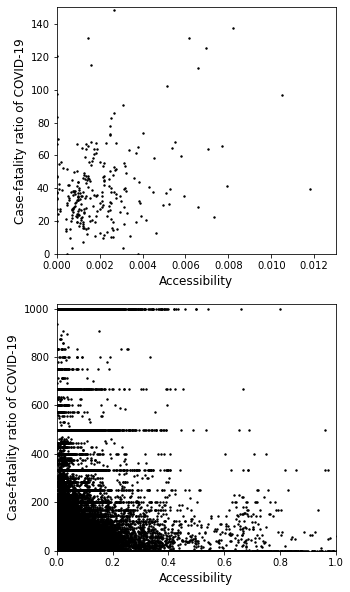

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(5, 10))

# Static
print(kendalltau(access_county_static['access'], fatality_county['fatality']))
axes[0].scatter(access_county_static['access'], fatality_county['fatality'],  color='black', s=2)
axes[0].set_xlabel('Accessibility', fontsize=12)
axes[0].set_ylabel('Case-fatality ratio of COVID-19', fontsize=12)
axes[0].set_ylim(0, 150)
axes[0].set_xlim(0, 0.013)

# Dynamic
print(kendalltau(corr_dynamic['access'], corr_dynamic['fatality']))
axes[1].scatter(corr_dynamic['access'], corr_dynamic['fatality'],  color='black', s=2)
axes[1].set_xlabel('Accessibility', fontsize=12)
axes[1].set_ylabel('Case-fatality ratio of COVID-19', fontsize=12)

axes[1].set_ylim(0, 1020)
axes[1].set_xlim(0, 1)

plt.show()

## 3.2. Retrospective relationship per county

In [20]:
kendall_dict = dict()
no_access_county = list()

pvalue_list = [] # For Bonferroni Correction

for idx, row in county_geom.iterrows():
    acc_ts = access_county_dynamic.loc[access_county_dynamic['County'] == row['County'], focus_date_dict.keys()].values[0]   
    death_ts = ave_fatality_geom.loc[ave_fatality_geom['County'] == row['County'], focus_date_dict.keys()].values[0]
    tau, taup = kendalltau(acc_ts, death_ts)
    pvalue_list.append(taup)
    
    kendall_dict[row['GEOID']] = dict()
    if tau is np.nan:
        kendall_dict[row['GEOID']]["coef"] = np.nan
        kendall_dict[row['GEOID']]["pval"] = np.nan
        kendall_dict[row['GEOID']]["notes"] = 'error'
    
    else:
        if taup < 0.05:
            kendall_dict[row['GEOID']]["coef"] = tau
            kendall_dict[row['GEOID']]["pval"] = taup
            kendall_dict[row['GEOID']]["notes"] = 'significant'
        
        else:
            kendall_dict[row['GEOID']]["coef"] = tau
            kendall_dict[row['GEOID']]["pval"] = taup
            kendall_dict[row['GEOID']]["notes"] = 'not significant'

    
coefs = [kendall_dict[ind]["coef"] for ind in county_geom["GEOID"]]
pvals = [kendall_dict[ind]["pval"] for ind in county_geom["GEOID"]]
notes = [kendall_dict[ind]["notes"] for ind in county_geom["GEOID"]]

# Convert Dictionary to DataFrame
kendall_df = pd.DataFrame({"GEOID": county_geom["GEOID"], "coefs": coefs, "pvals": pvals, "notes": notes})
kendall_df['GEOID'] = kendall_df['GEOID'].astype(str)

kendall_gdf = county_geom.merge(kendall_df, on='GEOID')

# Bonferroni Correction
kendall_gdf['bonferroni'] = sm.stats.multipletests(pvalue_list, 0.05, method='bonferroni')[0]
kendall_gdf.head(3)

,GEOID,TSA,pop,County,geometry,coefs,pvals,notes,bonferroni
0,48001,G,57810,Anderson,"POLYGON ((1440392.625 1070275.995, 1440394.136...",-0.067707,2.023583e-02,significant,False
1,48003,J,18036,Andrews,"POLYGON ((792219.493 1130103.506, 792219.283 1...",-0.368658,2.355981e-32,significant,True
2,48005,H,87322,Angelina,"POLYGON ((1527772.708 998471.159, 1527771.700 ...",0.021439,4.559888e-01,not significant,False


Number of valid results: 179
Number of counties without any access: 10
Number of invalid results: 65


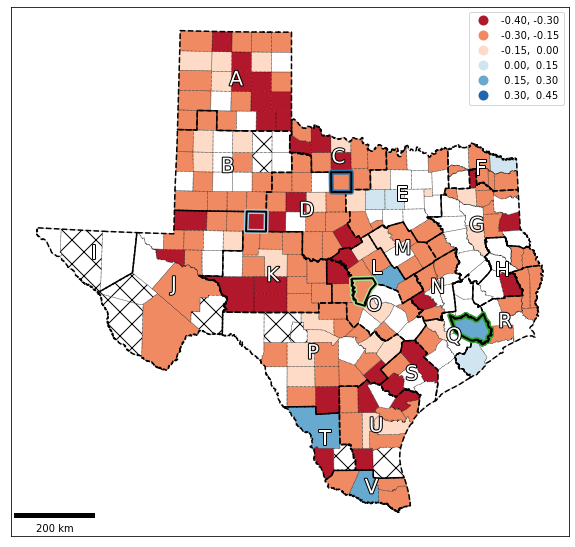

In [21]:
# Define color map
color_brewer = ['#b2182b','#ef8a62','#fddbc7','#d1e5f0','#67a9cf','#2166ac']
cm = LinearSegmentedColormap.from_list('cb_', color_brewer, N=6)

# Exploratory statistics for correlation analysis (retrospective relationship)
print(f"Number of valid results: {kendall_gdf.loc[kendall_gdf['bonferroni'] == True].shape[0]}")

no_access_county = access_county_static.loc[access_county_static['access'] == 0, 'County'].to_list()
print(f"Number of counties without any access: {kendall_gdf.loc[kendall_gdf['County'].isin(no_access_county)].shape[0]}")


print(f"Number of invalid results: {kendall_gdf.loc[(kendall_gdf['bonferroni'] == False) & (~kendall_gdf['County'].isin(no_access_county))].shape[0]}")

fig, ax = plt.subplots(figsize=(10,10))

ud = mapclassify.UserDefined(kendall_gdf['coefs'], [-0.3, -0.15, 0, 0.15, 0.3, 0.45])
kendall_gdf.loc[kendall_gdf['bonferroni'] == True].plot('coefs', ax=ax, cmap=cm, legend=True, scheme='UserDefined', classification_kwds={'bins': ud.bins})
kendall_gdf.loc[(kendall_gdf['bonferroni'] == False) & (~kendall_gdf['County'].isin(no_access_county))].plot(ax=ax, color='white')  # Locations with insignificant pearsonr correlation
kendall_gdf.loc[kendall_gdf['County'].isin(no_access_county)].plot(ax=ax, hatch='X', color='white')  # Locations without access to icu beds
# kendall_gdf.loc[(kendall_gdf['notes'] == 'error')].plot(ax=ax, hatch='X', color='white')  # Locations without access to icu beds

county_geom.boundary.plot(ax=ax, lw=0.5, color='black', linestyle='dotted')
tsa_geom.boundary.plot(ax=ax, lw=1.5, color='black', linestyle='dashed')

for idx, row in tsa_geom.iterrows(): # Iterate everyrow in `tsa` GeoDataFrame
    ax.text(s=row['TSA'], # String to be displayed; TSA name
            x=row['geometry'].centroid.coords[:][0][0], # X coordinate of label
            y=row['geometry'].centroid.coords[:][0][1], # Y coordinate of label
            fontsize=20, 
            color='white',
            ha='center', # Horizontal align
            va='center', # Vertical align
            path_effects=[pe.withStroke(linewidth=2, foreground="black")] # This will create boundary of text
           )

ax.add_artist(ScaleBar(dx=1, location='lower left'))
ax.get_xaxis().set_visible(False)  # Remove ticks and labels
ax.get_yaxis().set_visible(False)

coi = ['Mitchell', 'Young', 'Burnet', 'Harris']
color_bar = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

for idx, temp_county in enumerate(coi):
    county_geom.boundary[county_geom['County'] == temp_county].plot(ax=ax, lw=2, color='black', path_effects=[pe.withStroke(linewidth=5, foreground=color_bar[idx])])


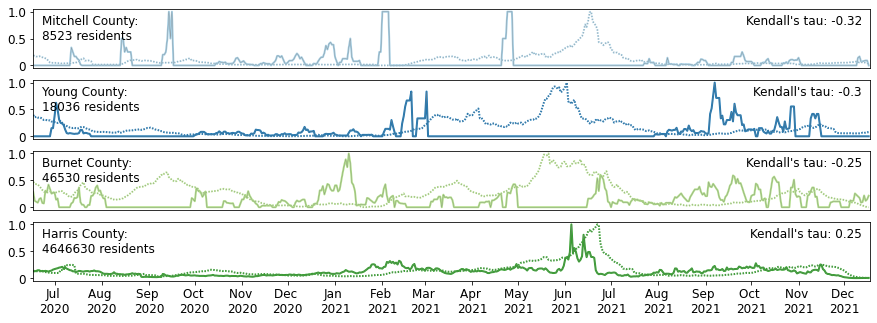

In [22]:
def normalize(ary):
    ary_ = ary.copy()
    ary_ = ary_.astype('float64')
    
    for idx, val in enumerate(ary):
        ary_[idx] = (val - ary.min()) / (ary.max() - ary.min())
        
    return ary_


coi = ['Mitchell', 'Young', 'Burnet', 'Harris']
color_bar = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']

period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]


fig, axes = plt.subplots(len(coi), 1, figsize=(15, 5))

for idx, temp_county in enumerate(coi):

    fatality_ts = ave_fatality_geom.loc[ave_fatality_geom['County'] == temp_county, focus_date_dict.keys()].values[0]
    fatality_ts[fatality_ts > 1000] = 1000
    axes[idx].plot(normalize(fatality_ts), color='grey', linewidth=0.3, path_effects=[pe.withStroke(linewidth=2, foreground=color_bar[idx])])
    

    access_ts = access_county_dynamic.loc[access_county_dynamic['County'] == temp_county, focus_date_dict.keys()].values[0]
    axes[idx].plot(normalize(access_ts), color='grey', linestyle=(0, (5, 5)), linewidth=0.3, path_effects=[pe.withStroke(linewidth=2, foreground=color_bar[idx])])
    
    temp_county_pop = ave_fatality_geom.loc[ave_fatality_geom['County'] == temp_county, 'pop'].values[0]
    axes[idx].text(0.01, 0.9, f'{temp_county} County: \n{temp_county_pop} residents', size=12, ha='left', va='top',transform=axes[idx].transAxes)
    
    temp_corr = round(kendall_gdf.loc[kendall_gdf['County'] == temp_county, 'coefs'].values[0], 2)
    axes[idx].text(0.99, 0.9, f"Kendall's tau: {temp_corr}", size=12, ha='right', va='top',transform=axes[idx].transAxes)
    axes[idx].set_xlim(0, len(focus_date_dict.keys()))
    axes[idx].set_yticks([0, 0.5, 1.0])
    axes[idx].set_yticklabels([0, 0.5, 1.0], fontsize=12)
    
    if idx == len(coi) - 1:
        axes[idx].set_xticks([list(focus_date_dict.keys()).index(val) for val in period])
        axes[idx].set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in period], fontsize=12)
    else:
        axes[idx].get_xaxis().set_visible(False)  # Remove ticks and labels


# 4. Inequality assessments

The Gini index is employed to explore the spatial inequality of ICU access for both static and dynamic measurements. We first compare the Gini index between static and dynamic measurements to examine how inequality would intensify when considering dynamics in ICU bed availability and confirmed COVID-19 cases. We then investigate the temporal changes of the disparity observed during the COVID-19 pandemic. Given dynamic changes in those variables were a substantial concern, we thoroughly assessed the inequality of access towards three different underlying attributes: cumulative distributions of location count, populations, and confirmed COVID-19 cases. 

In [23]:
def gini(temp_df, var_x, var_y):
    '''
    input: 
    temp_df: DataFrame that has at least two columns 
    var_x: varaible which denotes number of locations, population or confirmed COVID-19 cases
    var_y: variable which denotes accessibility
    
    output: 
    gini_coef: Gini coefficient
    x_: cumulative distribution of locations, population or confirmed COVID-19 cases
    y_: cumulative distribution of accessibility 
    
    '''
    
    # Sort dataframe based on the accessibility
    temp_df = temp_df.copy(deep=True)
    temp_df.sort_values(by=var_y, inplace=True)
    
    # Calculate cumulative distribution of accessibility 
    y_ = temp_df[var_y].cumsum() / temp_df[var_y].sum()
    y_ = y_.to_numpy()
    
    # Calculate cumulative distribution of locations, population or confirmed COVID-19 cases
    if var_x == 'locations':
        x_ = np.ones(temp_df.shape[0]).cumsum() / np.ones(temp_df.shape[0]).sum() 

    else:
        x_ = temp_df[var_x].cumsum() / temp_df[var_x].sum()
        x_ = x_.to_numpy()
    
    # Insert value 0 at the beginning of both array to faciliate the calculation of area drawn from Lorenz curve
    x_ = np.insert(x_, 0, 0, axis=0)
    y_ = np.insert(y_, 0, 0, axis=0)
    
    # Calculate area below Lorenz curve
    area_ = 0.0
    for i in range(1, len(x_)):
        area_ += (x_[i] - x_[i-1]) * (y_[i] + y_[i-1]) / 2. # Calculate area of parallelogram

    gini_coef = (0.5 - area_) / 0.5
        
    return gini_coef, x_, y_

In [24]:
# Prepare accessibility measures of static and dynamic measurements for Gini index calculation
access_tract_static = access_tract_static.merge(d_loc[['cases_tract']], left_index=True, right_index=True)
access_tract[list(focus_date_dict.keys())] = access_tract[focus_date_dict.keys()].mask(access_tract[focus_date_dict.keys()] > 1, 1)

# Calculate Gini index of each day
gini_pop_list = []
gini_loc_list = []
gini_case_list = []

# Replace accessibility to 1 if the value is greater than 1
access_tract[focus_date_dict.keys()].mask(access_tract[focus_date_dict.keys()] > 1, 1, inplace=True)

# for date in focus_date_dict.keys():
for date in tqdm(focus_date_dict.keys()):
    
    # Accessibility vs Population (2 variables)
    temp_gini_pop = gini(access_tract, 'pop', date)
    gini_pop_list.append(temp_gini_pop[0])
    
    # Accessibility vs Location counts (1 variable)
    temp_gini_loc = gini(access_tract, 'locations', date)
    gini_loc_list.append(temp_gini_loc[0])
    
    # Accessibility vs Confirmed cases (2 variables)
    access_tract_d_ = access_tract.filter(['GEOID', date])
    access_tract_d_.rename(columns={date: 'access'}, inplace=True)
    
    accum_case_ = d_val.filter(['GEOID', date])
    accum_case_.index = accum_case_.index.astype(str)
    accum_case_.rename(columns={date: 'cases'}, inplace=True)
    
    access_case_df = access_tract_d_.merge(accum_case_, left_index=True, right_index=True)

    temp_gini_case = gini(access_case_df, 'cases', 'access')
    gini_case_list.append(temp_gini_case[0])
    

100%|██████████| 549/549 [01:04<00:00,  8.49it/s]


Gini Index of Static Accessibility for Locations: 0.3011992065498752
Gini Index of Dynamic Accessibility for Location:
Max Gini of 0.536 on 12/31/2021
Min Gini of 0.343 on 11/30/2020
----------
Gini Index of Static Accessibility  for Population: 0.34704148040298677
Gini Index of Dynamic Accessibility for Population:
Max Gini of 0.586 on 12/31/2021
Min Gini of 0.373 on 11/30/2020
----------
Gini Index of Static Accessibility  for Cases: 0.3719011503424817
Gini Index of Dynamic Accessibility for Cases:
Max Gini of 0.75 on 12/31/2021
Min Gini of 0.442 on 11/29/2020


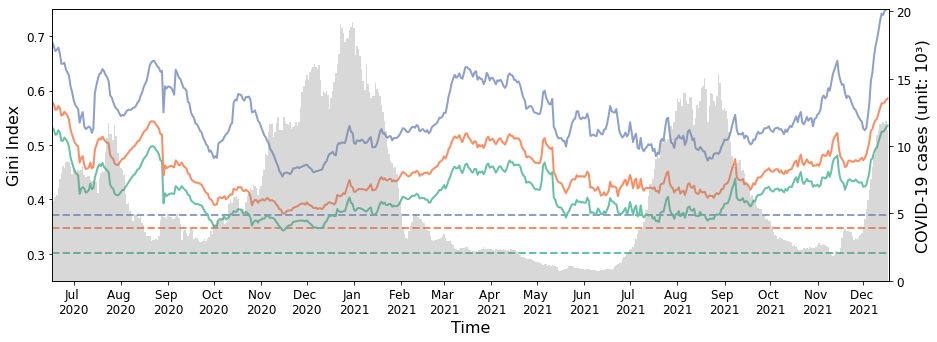

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
plot_colors = ['#66c2a5','#fc8d62','#8da0cb']

# Accessibility vs Location counts
gini_static_access_location = gini(access_tract_static, 'locations', 'access')
ax.hlines(gini_static_access_location[0], 0, len(focus_date_dict.keys()), color=plot_colors[0], linestyle='dashed', lw=2)
print(f'Gini Index of Static Accessibility for Locations: {gini_static_access_location[0]}')

ax.plot(gini_loc_list, plot_colors[0], lw=2)
print(f'''Gini Index of Dynamic Accessibility for Location:
Max Gini of {round(max(gini_loc_list), 3)} on {list(focus_date_dict.keys())[gini_loc_list.index(max(gini_loc_list))]}
Min Gini of {round(min(gini_loc_list), 3)} on {list(focus_date_dict.keys())[gini_loc_list.index(min(gini_loc_list))]}''')
print("----------")

# Accessibility vs Population
gini_static_access_pop = gini(access_tract_static, 'pop', 'access')
ax.hlines(gini_static_access_pop[0], 0, len(focus_date_dict.keys()), color=plot_colors[1], linestyle='dashed', lw=2)
print(f'Gini Index of Static Accessibility  for Population: {gini_static_access_pop[0]}')

ax.plot(gini_pop_list, color=plot_colors[1], lw=2)
print(f'''Gini Index of Dynamic Accessibility for Population:
Max Gini of {round(max(gini_pop_list), 3)} on {list(focus_date_dict.keys())[gini_pop_list.index(max(gini_pop_list))]}
Min Gini of {round(min(gini_pop_list), 3)} on {list(focus_date_dict.keys())[gini_pop_list.index(min(gini_pop_list))]}''')
print("----------")

# Accessibility vs Confirmed cases
gini_static_access_cases = gini(access_tract_static, 'cases_tract', 'access')
ax.hlines(gini_static_access_cases[0], 0, len(focus_date_dict.keys()), color=plot_colors[2], linestyle='dashed', lw=2)
print(f'Gini Index of Static Accessibility  for Cases: {gini_static_access_cases[0]}')

ax.plot(gini_case_list, color=plot_colors[2], lw=2)
print(f'''Gini Index of Dynamic Accessibility for Cases:
Max Gini of {round(max(gini_case_list), 3)} on {list(focus_date_dict.keys())[gini_case_list.index(max(gini_case_list))]}
Min Gini of {round(min(gini_case_list), 3)} on {list(focus_date_dict.keys())[gini_case_list.index(min(gini_case_list))]}''')

ax2 = ax.twinx()
ave_case_ary = ave_case[focus_date_dict.keys()].sum().to_numpy()
ax2.bar(focus_date_dict.keys(), ave_case_ary, width=1, facecolor='grey',  alpha=0.3)

period = ['07/15/2020', '08/15/2020', '09/15/2020', '10/15/2020', '11/15/2020', '12/15/2020',
          '01/15/2021', '02/15/2021', '03/15/2021', '04/15/2021', '05/15/2021', '06/15/2021',
          '07/15/2021', '08/15/2021', '09/15/2021', '10/15/2021', '11/15/2021', '12/15/2021'
         ]

ax.set_ylim(0.25, 0.75)
ax.set_xlim(0, len(focus_date_dict.keys()))
ax.set_xticks([list(focus_date_dict.keys()).index(val) for val in period])
ax.set_xticklabels([datetime.datetime.strptime(val, '%m/%d/%Y').strftime('%b \n%Y') for val in period], fontsize=12)
ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7])
ax.set_yticklabels([0.3, 0.4, 0.5, 0.6, 0.7], fontsize=12)

ax2.set_yticks([0, 5000, 10000, 15000, 20000])
ax2.set_yticklabels([0, 5, 10, 15, 20], fontsize=12)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Gini Index', fontsize=16)
ax2.set_ylabel('COVID-19 cases (unit: 10³)', fontsize=16)

plt.show()

# Done